#### SP Cashflow Modeling Presentation
---
#### Contents
- basic installment collateral cashflow forecast
- pass through
- warehouse structuring, scenario analysis, comprehensive analytics visuals
- securitization financing structuring, scenario analysis, comprehensive analytics visuals


In [10]:
from AssetModeling.Asset import Asset
from AssetModeling.Storage import AssetStore
from DealManager.Storage import MetricsReference
from StructureModeling.Storage import StructureStore
from DealManager.DealManager import DealManager
from DealManager.DealAnalytics import DealAnalytics
from Utils.SPCFUtils import SPCFUtils
from tabulate import tabulate
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
tabulatePrint = lambda x: print(tabulate(x, headers='keys', tablefmt='psql'))

#### Single collateral modeling. show curves, metrics, yield table

In [5]:

asset1 = Asset(**AssetStore.ASSETSTORE['consumerLoan70'])

In [6]:

tabulatePrint(asset1.getStaticMetrics()) # show static metric
tabulatePrint(asset1.calculateYieldTable(pxList = range(90,100))) # show yield talbe

+----+---------------+--------------------+
|    | matrics       | value              |
|----+---------------+--------------------|
|  0 | notional      | 1000000000.0       |
|  1 | wal           | 2.8189073052616025 |
|  2 | intRate       | 0.2                |
|  3 | term          | 70                 |
|  4 | intPmt        | 508827121.8388845  |
|  5 | prinPmt       | 834584000.0000006  |
|  6 | totalPmt      | 1330015438.2666132 |
|  7 | totalDefault  | 179799999.9999999  |
|  8 | totalLoss     | 165416000.0000001  |
|  9 | cnl           | 0.1654160000000001 |
| 10 | cgl           | 0.1797999999999999 |
| 11 | lossTiming    | 25/25/25/12/7/6    |
| 12 | defaultTiming | 25/25/25/12/7/6    |
+----+---------------+--------------------+
+----+------+----------+
|    |   px |    yield |
|----+------+----------|
|  0 |   90 | 0.174794 |
|  1 |   91 | 0.169314 |
|  2 |   92 | 0.163929 |
|  3 |   93 | 0.158636 |
|  4 |   94 | 0.153433 |
|  5 |   95 | 0.148316 |
|  6 |   96 | 0.143284 |
| 

#### ramp up portfolio and showing balance sheet build up and analytics

In [7]:
asset1.addRampSchedule(rampSchedule = "20 for 12", px = "100 for 6 98")

+----+----------------------+--------------+
|    | matrics              |        value |
|----+----------------------+--------------|
|  0 | purchasePeriod       | 12           |
|  1 | totalPurchaseBalance |  2.4e+08     |
|  2 | totalPurchaseBasis   |  2.376e+08   |
|  3 | avgPurchasePx        | 99           |
|  4 | peakBalance          |  2.17549e+08 |
|  5 | peakBalancePeriod    | 11           |
|  6 | wal                  |  3.27724     |
|  7 | breakevenPeriod      | 50           |
|  8 | totalPnL             |  8.16037e+07 |
|  9 | yield                |  0.128517    |
| 10 | moic                 |  1.34345     |
+----+----------------------+--------------+


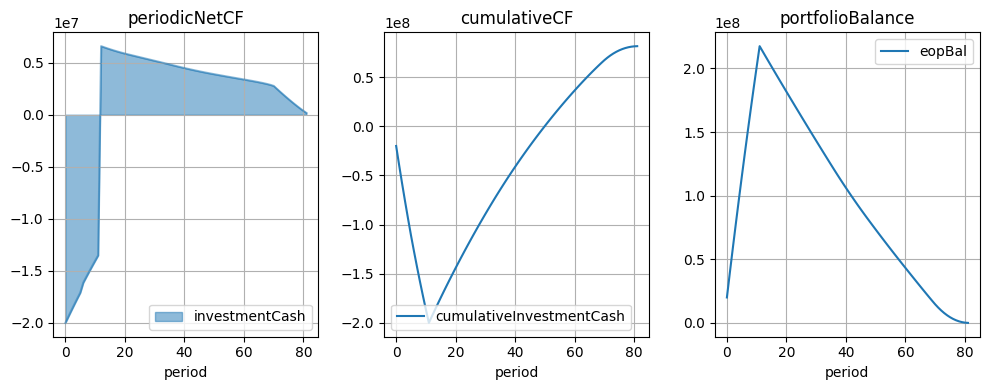

In [8]:
# show static metrices
print(tabulate(asset1.getStaticMetrics(ramp=True), headers='keys', tablefmt='psql'))

# show curves

figPageRamp, axPageRamp = plt.subplots(1,3, figsize=(10,4))
axPageRamp = axPageRamp.flatten()
for i, metrics in enumerate(MetricsReference.ASSETMETRICS['rampCurves']):
    df = asset1.getDynamicMetrics(metrics = metrics,ramp=True)
    if metrics == "periodicNetCF":
        df.plot.area(x = "period", ax = axPageRamp[i], grid = True, title=metrics, stacked = False)
    else:
        df.plot(x = "period", ax = axPageRamp[i], grid = True, title=metrics)

plt.tight_layout();plt.show()


#### Collateral scenarios. Static metrices and curves.

In [9]:
deal1 = DealManager(dealName = "plainCollateralDeal",
                    dealDescriptive = {"dealSubsector":"consumer loan",
                                       "dealSector":"Consumer",
                                       "assetOriginator":"SuperLoan"                                       
                        },
                    dealMisc = {"upfrontFees": 1e6},
                    assetScenarios = {"base": AssetStore.ASSETSTORE['consumerLoan70']},
                    )
deal1.copyAssetWithNewAssumption("base", "frontLoad", {"defaultTimingCurve": SPCFUtils.timingCurveParse("32/32/15", term = 70)})
deal1.copyAssetWithNewAssumption("base", "backLoad", {"defaultTimingCurve": SPCFUtils.timingCurveParse("10/10/10", term = 70)})


In [11]:
deal1Analytics = DealAnalytics(deal1)
deal1Analytics.presentDeal()
# show static metrices
# show curves
# figPageCollatCurve, axPageCollatCurve = plt.subplots(2,3, figsize=(10,8))
# axPageCollatCurve = axPageCollatCurve.flatten()
# for i, metrics in enumerate(MetricsReference.ASSETMETRICS['6Curves']):
#     deal1.getAssetDynamicMetrics(metrics).plot(x = "period", ax = axPageCollatCurve[i], grid = True, title=metrics)

# plt.tight_layout();plt.show()




*********************************
******     Capital Stack      ******
*********************************
  class  size  coupon  advRate
0     A   0.0     0.0        0


*************************************************************
******     Asset Economics (single one without ramp)      ******
*************************************************************
                            base          frontLoad           backLoad
matrics/px                                                            
notional            1000000000.0       1000000000.0       1000000000.0
wal                     2.818907           2.839593            2.70339
intRate                      0.2                0.2                0.2
term                          70                 70                 70
intPmt          508827121.838884   504580921.847137   532441210.236016
prinPmt         834584000.000001   834584000.000002    835056770.93398
totalPmt       1330015438.266613  1325882796.880115  1353469645.440166
t

#### Pass-through (0 adv rate ABS structure). Bake in deal fees, and show economics under different assumption

In [12]:


deal2 = DealManager(dealName = "PTDeal",
                    dealDescriptive = {"dealSubsector":"subprime auto",
                                       "dealSector":"Consumer",
                                       "assetOriginator":"SuperLoan"                                       
                        },
                    dealMisc = {"upfrontFees": 1e6},
                    assetScenarios = {"base": AssetStore.ASSETSTORE['autoLoan45']},
                    financingTerms = StructureStore.STRUCTURESTORE['PT']
                    )

deal2.copyAssetWithNewAssumption("base", "frontLoad", {"defaultTimingCurve": SPCFUtils.timingCurveParse("37/37/20", term = 45)})
deal2.copyAssetWithNewAssumption("base", "backLoad", {"defaultTimingCurve": SPCFUtils.timingCurveParse("10/10/10", term = 45)})
deal2Analytics = DealAnalytics(deal2)
deal2Analytics.presentDeal()



*********************************
******     Capital Stack      ******
*********************************
  class  size  coupon  advRate
0     A   0.0     0.0        0


*************************************************************
******     Asset Economics (single one without ramp)      ******
*************************************************************
                            base          frontLoad           backLoad
matrics/px                                                            
notional            1000000000.0       1000000000.0       1000000000.0
wal                     1.843778            1.85225           1.840158
intRate                     0.18               0.18               0.18
term                          45                 45                 45
intPmt          301056821.373777    293896807.38978   306057234.827518
prinPmt         934000000.000001   934000000.000005   935136656.192565
totalPmt       1220403447.732052  1213606487.641177  1226290151.443001
t

#### A/B cut. (70/30 ABS Structure). single tranche term ABS.

In [13]:


dealABCut = DealManager(dealName = "ABCutonConsumerLoan",
                    dealDescriptive = {"dealSubsector":"consumer loan",
                                       "dealSector":"Consumer",
                                       "assetOriginator":"SuperLoan"                                       
                        },
                    dealMisc = {"upfrontFees": 1e6},
                    assetScenarios = {"base": AssetStore.ASSETSTORE['consumerLoan58']},
                    financingTerms = StructureStore.STRUCTURESTORE['ABCut']
                    )

dealABCut.copyAssetWithNewAssumption("base", "frontLoad", {"defaultTimingCurve": SPCFUtils.timingCurveParse("50/35/10", term = 58)})
dealABCut.copyAssetWithNewAssumption("base", "backLoad", {"defaultTimingCurve": SPCFUtils.timingCurveParse("10/10/10", term = 58)})
dealABCut.addSeriesDefaultScenario(startingMultiple=1.0, endingMultiple=2.5, step=0.5)
dealABCutAnalytics = DealAnalytics(dealABCut)
dealABCutAnalytics.presentDeal()
# figPageCollat, axPageCollat = plt.subplots(2,3, figsize=(10,4))
# axPageCollat = axPageCollat.flatten()
# for i, metrics in enumerate(['cdrCurve','cprCurve','sevCurve','dqCurve','cnlCurve','factorCurve']):
#     df = dealABCut.getAssetDynamicMetrics(metrics)
#     df.plot(x = "period", ax = axPageCollat[i], grid = True, title=metrics)
# plt.tight_layout();plt.show()




*********************************
******     Capital Stack      ******
*********************************
  class        size  coupon  advRate
0     A  70000000.0    0.07       70


*************************************************************
******     Asset Economics (single one without ramp)      ******
*************************************************************
                            base          frontLoad           backLoad  \
matrics/px                                                               
notional            1000000000.0       1000000000.0       1000000000.0   
wal                     2.350922           2.378238           2.217429   
intRate                   0.1922             0.1922             0.1922   
term                          58                 58                 58   
intPmt          397837075.204677   392624707.978317   425393241.138716   
prinPmt         834400000.000002   834400000.000003   838013820.683128   
totalPmt       1221332571.483265  12

#### securitization financing structuring, scenario analysis, comprehensive analytics visuals

In [14]:
dealConsumerLoanABS = DealManager(dealName = "UPST2302",
                    dealDescriptive = {"dealSubsector":"consumer loan",
                                       "dealSector":"Consumer",
                                       "assetOriginator":"Upstart"                                       
                        },
                    rampSchedule = {"ramp": "204", "px":100},
                    dealMisc = {"upfrontFees": 1e6},
                    assetScenarios = {"base": AssetStore.ASSETSTORE['consumerLoanUpstart2302']},
                    financingTerms = StructureStore.STRUCTURESTORE['ConsumerABS']
                    )
dealConsumerLoanABS.copyAssetWithNewAssumption("base", "frontLoad", {"defaultTimingCurve": SPCFUtils.timingCurveParse("50/35/10/5", term = 56)})
dealConsumerLoanABS.copyAssetWithNewAssumption("base", "backLoad", {"defaultTimingCurve": SPCFUtils.timingCurveParse("25/40/20/15", term = 56)})
dealConsumerLoanABS.copyAssetWithNewAssumption("base", "baseAlt", {"defaultTimingCurve": None,
                                                                   "totalDefault": None,
                                                                   "cdrVector": SPCFUtils.convertIntexRamp("0 ramp 10 20 20 ramp 6 15", term = 56, divisor = 100)
                                                                   }
                                                                   )

dealConsumerLoanABS.addSeriesDefaultScenario(startingMultiple=1.5, endingMultiple=2.0, step=0.5, baseScenario="base")
dealConsumerLoanABSAnalytics = DealAnalytics(dealConsumerLoanABS)
dealConsumerLoanABSAnalytics.presentDeal()





*********************************
******     Capital Stack      ******
*********************************
  class         size  coupon  advRate
0     A  108732000.0  0.0677    53.30
1     B   27438000.0  0.0792    66.75
2     C   37230000.0  0.1187    85.00


*************************************************************
******     Asset Economics (single one without ramp)      ******
*************************************************************
                            base          frontLoad           backLoad  \
matrics/px                                                               
notional            1000000000.0       1000000000.0       1000000000.0   
wal                     2.284139            2.31269           2.258541   
intRate                   0.2175             0.2175             0.2175   
term                          56                 56                 56   
intPmt          431382181.901791   424654316.358657   436557632.743418   
prinPmt         813128986.666668

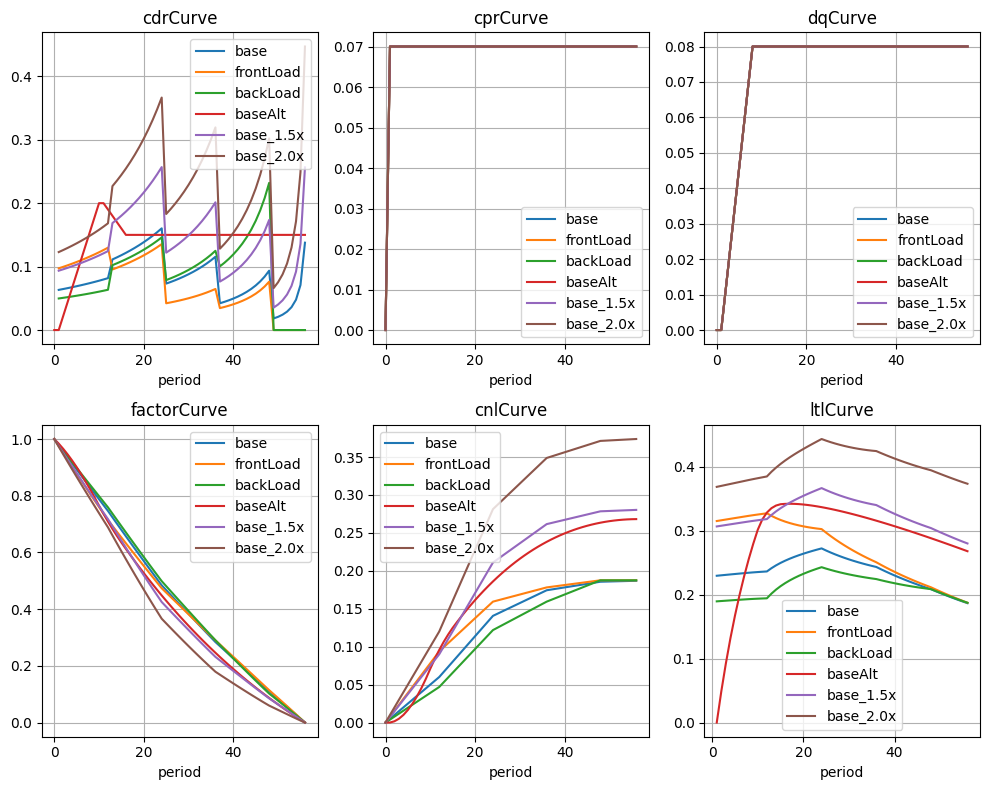

In [6]:
figPageCollatCurve, axPageCollatCurve = plt.subplots(2,3, figsize=(10,8))
axPageCollatCurve = axPageCollatCurve.flatten()
for i, metrics in enumerate(MetricsReference.ASSETMETRICS['6Curves']):
    dealConsumerLoanABS.getAssetDynamicMetrics(metrics).plot(x = "period", ax = axPageCollatCurve[i], grid = True, title=metrics)
plt.tight_layout();plt.show()

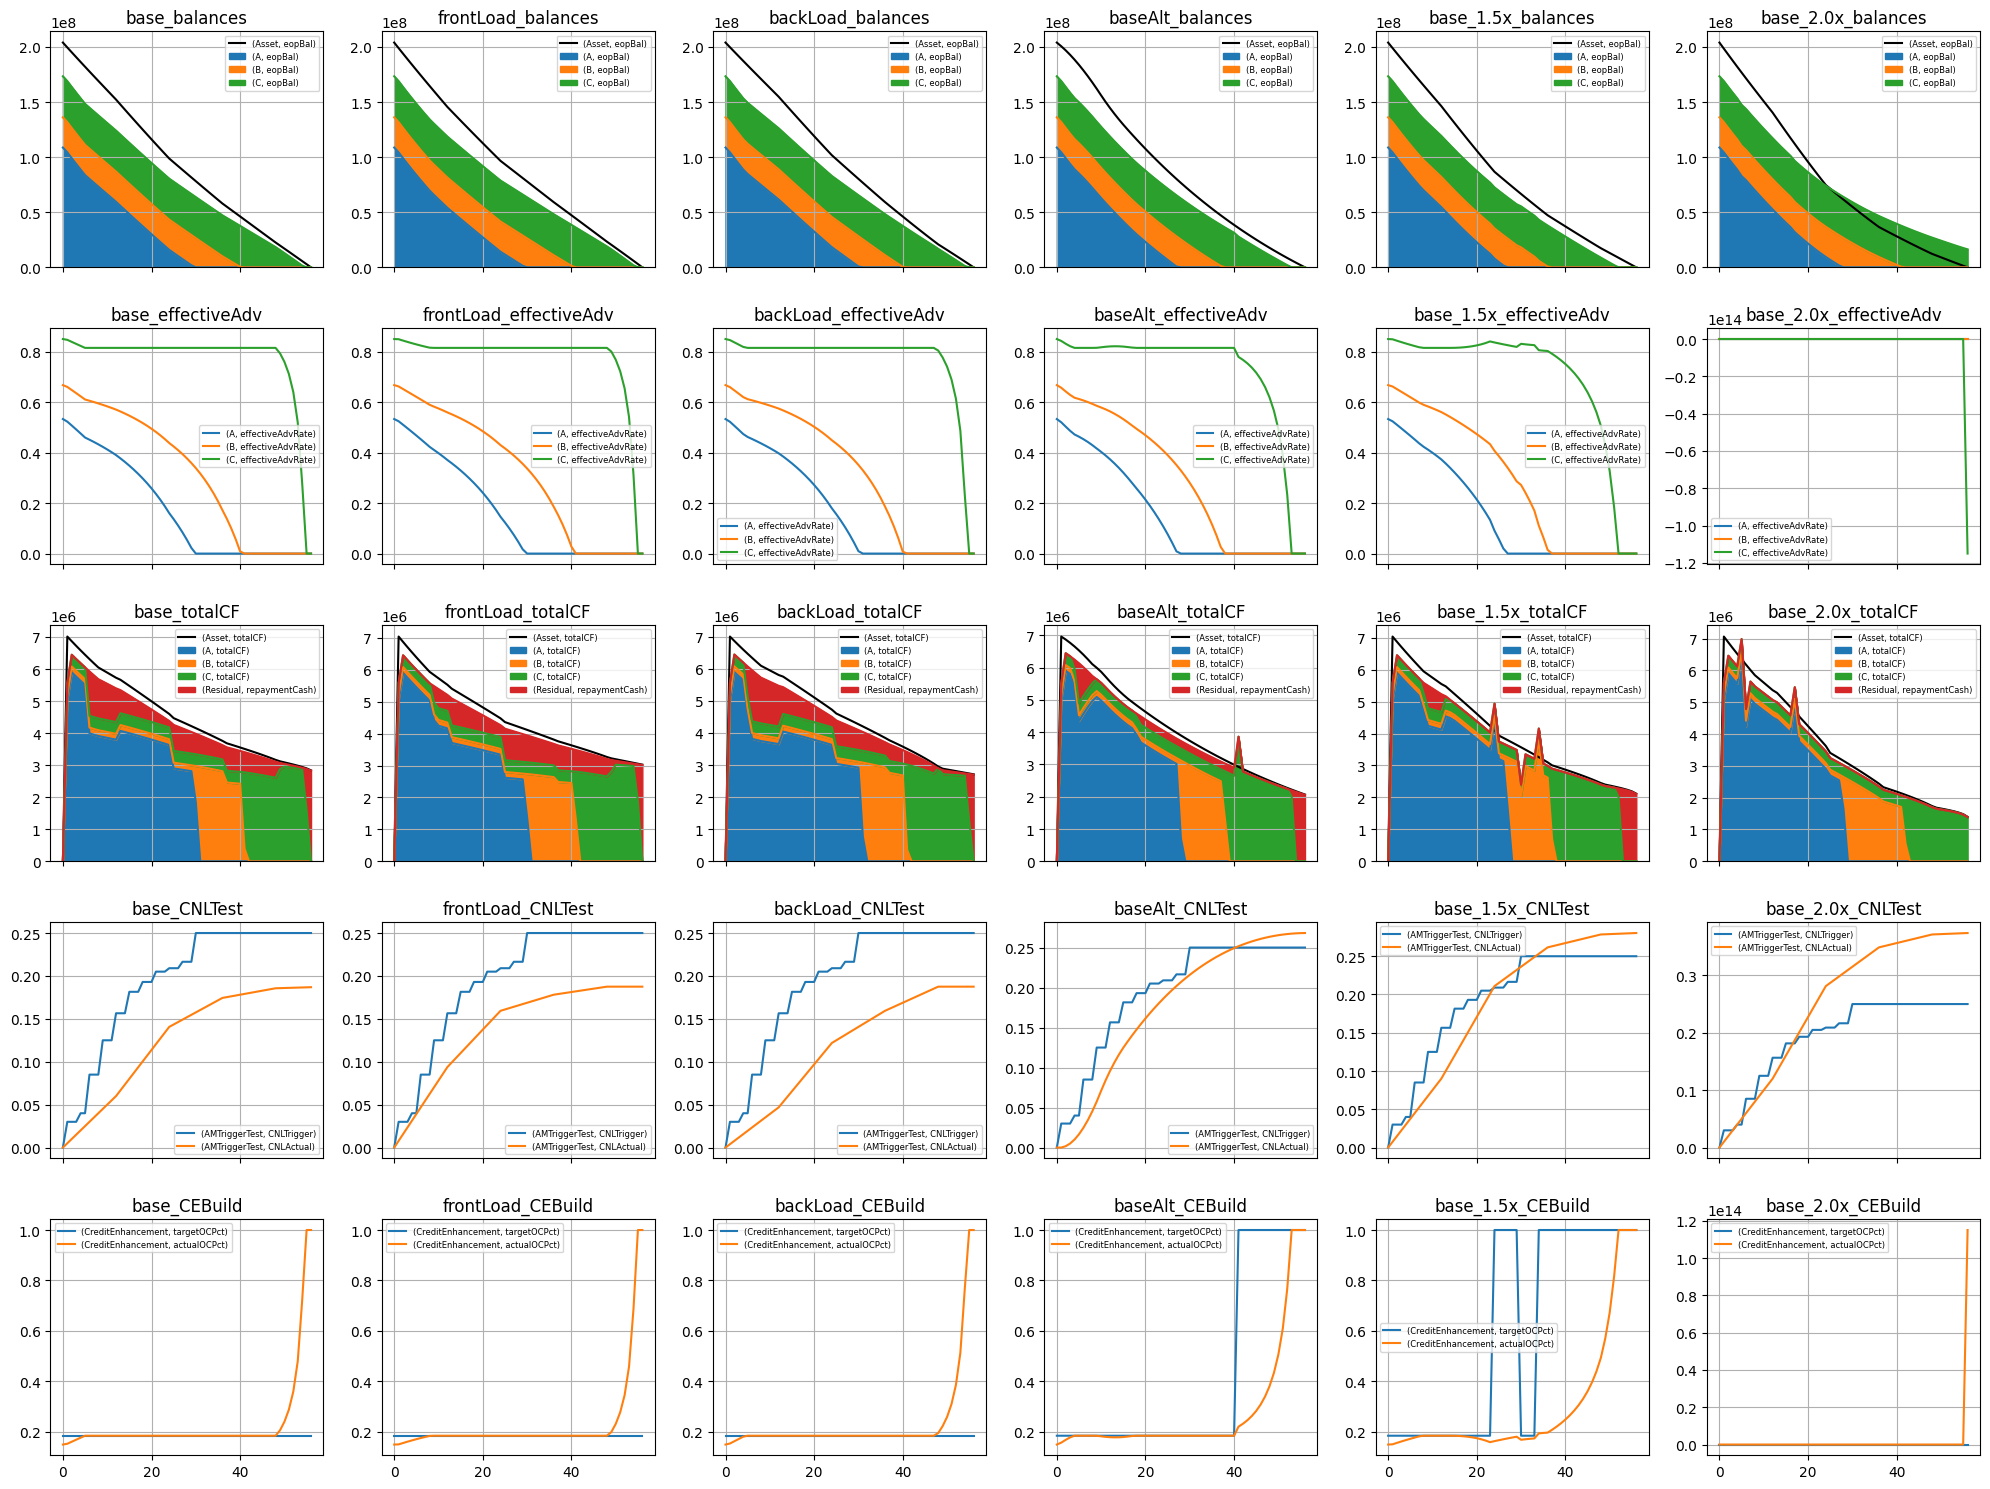

In [7]:

figPageStructCurve, axPageStructCurve = plt.subplots(5,dealConsumerLoanABS.getScenarioCount(), figsize=(20,15), sharex=True)
for i, metrics in enumerate(MetricsReference.STRUCTUREMETRICS['5Curves']):
    for j, scenario in enumerate(dealConsumerLoanABS.getScenarioNames()):
        df = dealConsumerLoanABS.getStructureDynamicMetrics(metrics)[scenario]
        if metrics in MetricsReference.STRUCTURESTACKED:
            df.loc[:, ["Asset"]].plot(ax = axPageStructCurve[i,j], grid = True, title=scenario+"_"+metrics, color = "black")            
            df.drop("Asset", axis = 1).plot.area(ax = axPageStructCurve[i,j], stacked = True, grid = True, title=scenario+"_"+metrics)
        else:
            df.plot(ax = axPageStructCurve[i,j], grid = True, title=scenario+"_"+metrics)
        axPageStructCurve[i,j].set_xlabel("")
        axPageStructCurve[i,j].legend(fontsize="6")

plt.tight_layout();plt.show()

#### warehouse structuring, scenario analysis, comprehensive analytics visuals

In [ ]:
dealConsumerLoanWH = DealManager(dealName = "UPST2302",
                                 dealDescriptive = {"dealSubsector":"consumer loan",

                                       "dealSector":"Consumer",
                                       "assetOriginator":"Upstart"                                       
                        },
                    rampSchedule = {"ramp": "100 100", "px":"100 100"},
                    dealMisc = {"upfrontFees": 1e6},
                    assetScenarios = {"base": AssetStore.ASSETSTORE['consumerLoanUpstart2302']},
                    financingTerms = StructureStore.STRUCTURESTORE['WH']
                    )

dealConsumerLoanWHAnalytics = DealAnalytics(dealConsumerLoanWH)
dealConsumerLoanWHAnalytics.presentDeal()